In [135]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [137]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Naive Implementation

In [141]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

## Likelihood Ratios

In [142]:
N = 10**6
m = np.load(filestr + 'm_{}.npy'.format(N))
s = np.load(filestr + 's_{}.npy'.format(N))

# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model, m, s)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = pure_lr(mlc_model, m, s)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = pure_lr(sqr_model, m, s)

In [143]:
xs = np.linspace(-6, 6, 1201)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs, xs), xs) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs, xs), xs) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs, xs), xs) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs, xs), xs) + ('SQR',)

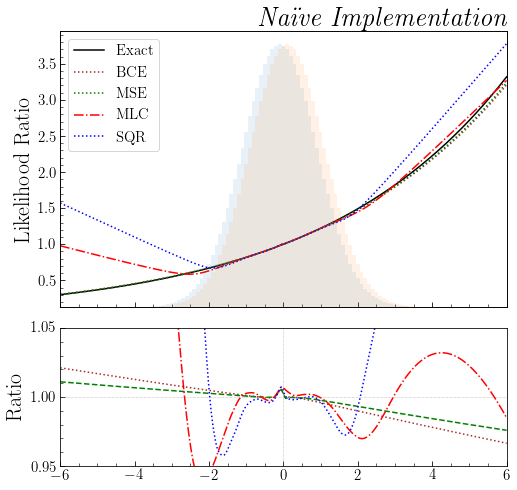

In [147]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, bce_lr[0], c = 'brown', ls = ':', label = 'BCE')
axs[0].plot(xs, mse_lr[0], c = 'green', ls = ':', label = 'MSE')
axs[0].plot(xs, mlc_lr[0], c = 'red', ls = '-.', label = 'MLC')
axs[0].plot(xs, sqr_lr[0], c = 'blue', ls = ':', label = 'SQR')
axs[0].set_xlim(-6, 6)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, bce_lrr[0], c = 'brown', ls = ':')
axs[1].plot(xs, mse_lrr[0], c = 'green', ls = '--')
axs[1].plot(xs, mlc_lrr[0], c = 'red', ls = '-.')
axs[1].plot(xs, sqr_lrr[0], c = 'blue', ls = ':')
axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.title(r'\it Na\"ive Implementation', loc = 'right')
plt.savefig('plots/paper/naive_fit.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

## MAEs

In [148]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = pure_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = pure_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

100
1000
10000
100000
1000000
10000000


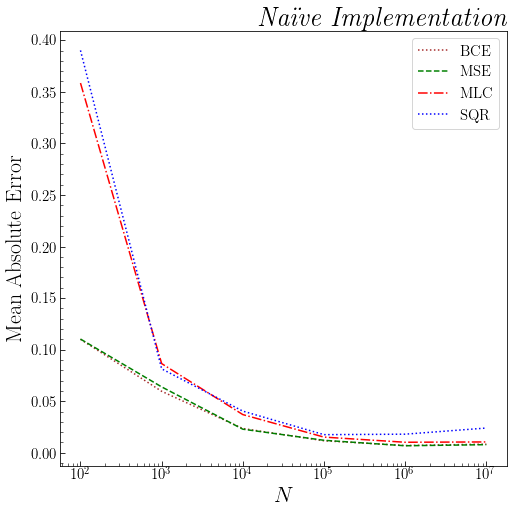

In [149]:
# Plot MAEs
fig, ax = plt.subplots(figsize = (8, 8))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='-.', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls=':', label='SQR')
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.xscale("log", base=10)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r'\it Na\"ive Implementation', loc="right");
plt.savefig('plots/paper/naive_sizes.png',
            transparent = True,
            dpi=300, 
            bbox_inches='tight')

# $C$ Parametrization

## BCE & MSE $C$ Parametrization

In [10]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
bce_params_1 = {'loss':bce}
bce_params_2 = {'loss':tanh_bce, 'output': 'linear'}
bce_params_3 = {'loss':atan_bce, 'output': 'linear'}

mse_params_1 = {'loss':mse}
mse_params_2 = {'loss':tanh_mse, 'output': 'linear'}
mse_params_3 = {'loss':atan_mse, 'output': 'linear'}

bce_filestr = 'models/univariate/bce_c_param/set_{}/'.format(num)
bce_filestr_1 = bce_filestr + 'linear/model_{}.h5'
bce_filestr_2 = bce_filestr + 'tanh/model_{}.h5'
bce_filestr_3 = bce_filestr + 'atan/model_{}.h5'

mse_filestr = 'models/univariate/mse_c_param/set_{}/'.format(num)
mse_filestr_1 = mse_filestr + 'linear/model_{}.h5'
mse_filestr_2 = mse_filestr + 'tanh/model_{}.h5'
mse_filestr_3 = mse_filestr + 'atan/model_{}.h5'

bce_m = np.load(bce_filestr + 'm.npy')
bce_s = np.load(bce_filestr + 's.npy')

mse_m = np.load(mse_filestr + 'm.npy')
mse_s = np.load(mse_filestr + 's.npy')

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Likelihood Ratios

In [11]:
# Load in models.
bce_lrs_1 = [None] * reps
bce_lrs_2 = [None] * reps
bce_lrs_3 = [None] * reps

mse_lrs_1 = [None] * reps
mse_lrs_2 = [None] * reps
mse_lrs_3 = [None] * reps
for i in range(reps):
    bce_model_1 = create_model(**bce_params_1)
    bce_model_2 = create_model(**bce_params_2)
    bce_model_3 = create_model(**bce_params_3)
    
    bce_model_1.load_weights(bce_filestr_1.format(i))
    bce_model_2.load_weights(bce_filestr_2.format(i))
    bce_model_3.load_weights(bce_filestr_3.format(i))
    
    bce_lrs_1[i] = odds_lr(bce_model_1, bce_m, bce_s)
    bce_lrs_2[i] = tanh_lr(bce_model_2, bce_m, bce_s)
    bce_lrs_3[i] = atan_lr(bce_model_3, bce_m, bce_s)
    
    mse_model_1 = create_model(**mse_params_1)
    mse_model_2 = create_model(**mse_params_2)
    mse_model_3 = create_model(**mse_params_3)
    
    mse_model_1.load_weights(mse_filestr_1.format(i))
    mse_model_2.load_weights(mse_filestr_2.format(i))
    mse_model_3.load_weights(mse_filestr_3.format(i))
    
    mse_lrs_1[i] = odds_lr(mse_model_1, mse_m, mse_s)
    mse_lrs_2[i] = tanh_lr(mse_model_2, mse_m, mse_s)
    mse_lrs_3[i] = atan_lr(mse_model_3, mse_m, mse_s)

In [12]:
xs = np.linspace(-6, 6, 1201)

bce_preds_1 = get_preds(bce_lrs_1, xs)
bce_preds_2 = get_preds(bce_lrs_2, xs)
bce_preds_3 = get_preds(bce_lrs_3, xs)
mse_preds_1 = get_preds(mse_lrs_1, xs)
mse_preds_2 = get_preds(mse_lrs_2, xs)
mse_preds_3 = get_preds(mse_lrs_3, xs)

bce_lr_1 = avg_lr(bce_preds_1)
bce_lr_2 = avg_lr(bce_preds_2)
bce_lr_3 = avg_lr(bce_preds_3)
mse_lr_1 = avg_lr(mse_preds_1)
mse_lr_2 = avg_lr(mse_preds_2)
mse_lr_3 = avg_lr(mse_preds_3)

bce_lrr_1 = avg_lrr(lr, bce_preds_1, xs)
bce_lrr_2 = avg_lrr(lr, bce_preds_2, xs)
bce_lrr_3 = avg_lrr(lr, bce_preds_3, xs)
mse_lrr_1 = avg_lrr(lr, mse_preds_1, xs)
mse_lrr_2 = avg_lrr(lr, mse_preds_2, xs)
mse_lrr_3 = avg_lrr(lr, mse_preds_3, xs)

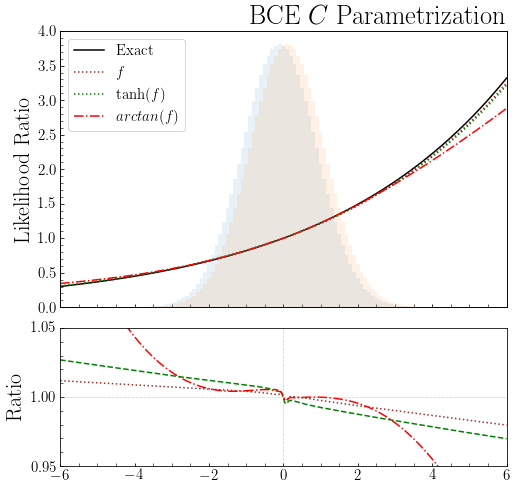

In [13]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, bce_lr_1[0], c = 'brown', ls = ':', label = r'$f$')
axs[0].plot(xs, bce_lr_2[0], c = 'green', ls = ':', label = r'$\tanh(f)$')
axs[0].plot(xs, bce_lr_3[0], c = 'red', ls = '-.', label = r'$\arctan(f)$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'BCE $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, bce_lrr_1[0], c = 'brown', ls = ':')
axs[1].plot(xs, bce_lrr_2[0], c = 'green', ls = '--')
axs[1].plot(xs, bce_lrr_3[0], c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/bce_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

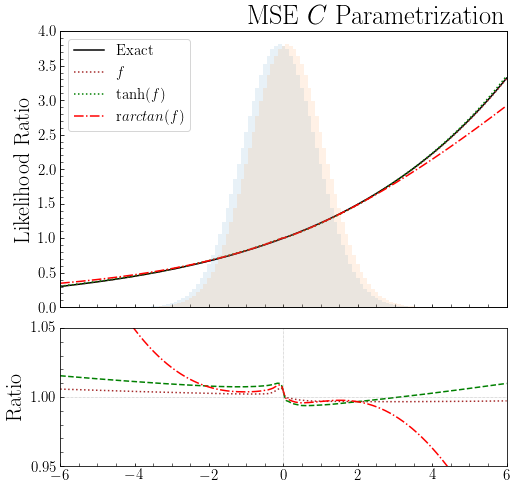

In [14]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, mse_lr_1[0], c = 'brown', ls = ':', label = r'$f$')
axs[0].plot(xs, mse_lr_2[0], c = 'green', ls = ':', label = r'$\tanh(f)$')
axs[0].plot(xs, mse_lr_3[0], c = 'red', ls = '-.', label = 'r$\arctan(f)$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'MSE $C$ Parametrization', loc = 'right')

hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

axs[1].plot(xs, mse_lrr_1[0], c = 'brown', ls = ':')
axs[1].plot(xs, mse_lrr_2[0], c = 'green', ls = '--')
axs[1].plot(xs, mse_lrr_3[0], c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/mse_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs

In [15]:
# Calculate mean absolute errors
bce_maes_1 = [mae(lr) for lr in bce_lrs_1]
bce_maes_2 = [mae(lr) for lr in bce_lrs_2]
bce_maes_3 = [mae(lr) for lr in bce_lrs_3]

mse_maes_1 = [mae(lr) for lr in mse_lrs_1]
mse_maes_2 = [mae(lr) for lr in mse_lrs_2]
mse_maes_3 = [mae(lr) for lr in mse_lrs_3]

bce_avg_1 = np.mean(bce_maes_1)
bce_avg_2 = np.mean(bce_maes_2)
bce_avg_3 = np.mean(bce_maes_3)

mse_avg_1 = np.mean(mse_maes_1)
mse_avg_2 = np.mean(mse_maes_2)
mse_avg_3 = np.mean(mse_maes_3)

print(bce_avg_1, bce_avg_2, bce_avg_3)
print(mse_avg_1, mse_avg_2, mse_avg_3)

0.006326569852379711 0.010670640665592621 0.007373237817989721
0.00647061202943552 0.011401208848961057 0.008216221460353237


## MLC & SQR $C$ Parametrization

In [64]:
# Experiment parameters
num = 5
reps = 100

# Model parameters
mlc_params_1 = {'loss':mlc, 'output': 'relu'}
mlc_params_2 = {'loss':square_mlc, 'output': 'linear'}
mlc_params_3 = {'loss':exp_mlc, 'output': 'linear'}

sqr_params_1 = {'loss':sqr, 'output': 'relu'}
sqr_params_2 = {'loss':square_sqr, 'output': 'linear'}
sqr_params_3 = {'loss':exp_sqr, 'output': 'linear'}

mlc_filestr = 'models/univariate/mlc_c_param/set_{}/'.format(num)
mlc_filestr_1 = mlc_filestr + 'linear/model_{}.h5'
mlc_filestr_2 = mlc_filestr + 'square/model_{}.h5'
mlc_filestr_3 = mlc_filestr + 'exponl/model_{}.h5'

sqr_filestr = 'models/univariate/sqr_c_param/set_{}/'.format(num)
sqr_filestr_1 = sqr_filestr + 'linear/model_{}.h5'
sqr_filestr_2 = sqr_filestr + 'square/model_{}.h5'
sqr_filestr_3 = sqr_filestr + 'exponl/model_{}.h5'

mlc_m = np.load(mlc_filestr + 'm.npy')
mlc_s = np.load(mlc_filestr + 's.npy')

sqr_m = np.load(sqr_filestr + 'm.npy')
sqr_s = np.load(sqr_filestr + 's.npy')

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Likelihood Ratios

In [65]:
# Load in models.
mlc_lrs_1 = [None] * reps
mlc_lrs_2 = [None] * reps
mlc_lrs_3 = [None] * reps

sqr_lrs_1 = [None] * reps
sqr_lrs_2 = [None] * reps
sqr_lrs_3 = [None] * reps
for i in range(reps):
    mlc_model_1 = create_model(**mlc_params_1)
    mlc_model_2 = create_model(**mlc_params_2)
    mlc_model_3 = create_model(**mlc_params_3)
    
    mlc_model_1.load_weights(mlc_filestr_1.format(i))
    mlc_model_2.load_weights(mlc_filestr_2.format(i))
    mlc_model_3.load_weights(mlc_filestr_3.format(i))
    
    mlc_lrs_1[i] = pure_lr(mlc_model_1, mlc_m, mlc_s)
    mlc_lrs_2[i] = square_lr(mlc_model_2, mlc_m, mlc_s)
    mlc_lrs_3[i] = exp_lr(mlc_model_3, mlc_m, mlc_s)
    
    sqr_model_1 = create_model(**sqr_params_1)
    sqr_model_2 = create_model(**sqr_params_2)
    sqr_model_3 = create_model(**sqr_params_3)
    
    sqr_model_1.load_weights(sqr_filestr_1.format(i))
    sqr_model_2.load_weights(sqr_filestr_2.format(i))
    sqr_model_3.load_weights(sqr_filestr_3.format(i))
    
    sqr_lrs_1[i] = pure_lr(sqr_model_1, sqr_m, sqr_s)
    sqr_lrs_2[i] = square_lr(sqr_model_2, sqr_m, sqr_s)
    sqr_lrs_3[i] = exp_lr(sqr_model_3, sqr_m, sqr_s)

In [66]:
xs = np.linspace(-6, 6, 1201)

mlc_preds_1 = get_preds(mlc_lrs_1, xs)
mlc_preds_2 = get_preds(mlc_lrs_2, xs)
mlc_preds_3 = get_preds(mlc_lrs_3, xs)
sqr_preds_1 = get_preds(sqr_lrs_1, xs)
sqr_preds_2 = get_preds(sqr_lrs_2, xs)
sqr_preds_3 = get_preds(sqr_lrs_3, xs)

mlc_lr_1 = avg_lr(mlc_preds_1)
mlc_lr_2 = avg_lr(mlc_preds_2)
mlc_lr_3 = avg_lr(mlc_preds_3)
sqr_lr_1 = avg_lr(sqr_preds_1)
sqr_lr_2 = avg_lr(sqr_preds_2)
sqr_lr_3 = avg_lr(sqr_preds_3)

mlc_lrr_1 = avg_lrr(lr, mlc_preds_1, xs)
mlc_lrr_2 = avg_lrr(lr, mlc_preds_2, xs)
mlc_lrr_3 = avg_lrr(lr, mlc_preds_3, xs)
sqr_lrr_1 = avg_lrr(lr, sqr_preds_1, xs)
sqr_lrr_2 = avg_lrr(lr, sqr_preds_2, xs)
sqr_lrr_3 = avg_lrr(lr, sqr_preds_3, xs)

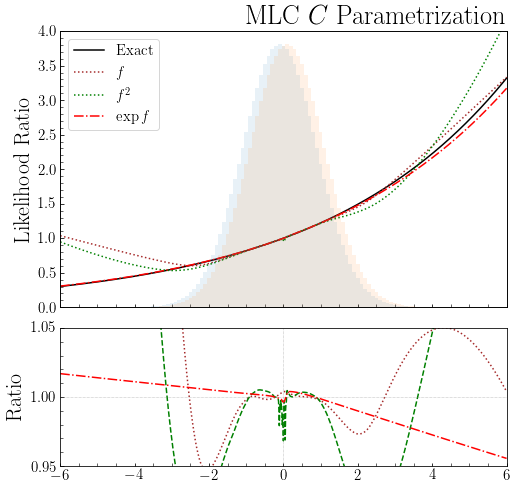

In [67]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, mlc_lr_1[0], c = 'brown', ls = ':', label = r'$f$')
axs[0].plot(xs, mlc_lr_2[0], c = 'green', ls = ':', label = r'$f^2$')
axs[0].plot(xs, mlc_lr_3[0], c = 'red', ls = '-.', label = r'$\exp{f}$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'MLC $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, mlc_lrr_1[0], c = 'brown', ls = ':')
axs[1].plot(xs, mlc_lrr_2[0], c = 'green', ls = '--')
axs[1].plot(xs, mlc_lrr_3[0], c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/mlc_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

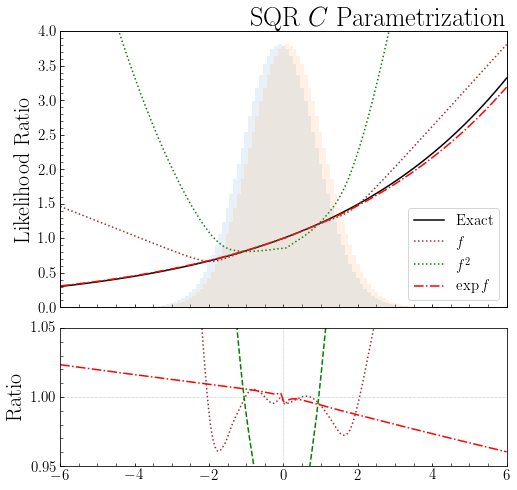

In [21]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, sqr_lr_1[0], c = 'brown', ls = ':', label = r'$f$')
axs[0].plot(xs, sqr_lr_2[0], c = 'green', ls = ':', label = r'$f^2$')
axs[0].plot(xs, sqr_lr_3[0], c = 'red', ls = '-.', label = r'$\exp{f}$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'SQR $C$ Parametrization', loc = 'right')

hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

axs[1].plot(xs, sqr_lrr_1[0], c = 'brown', ls = ':')
axs[1].plot(xs, sqr_lrr_2[0], c = 'green', ls = '--')
axs[1].plot(xs, sqr_lrr_3[0], c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/sqr_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs


In [14]:
# Calculate mean absolute errors
mlc_maes_1 = [mae(lr) for lr in mlc_lrs_1]
mlc_maes_2 = [mae(lr) for lr in mlc_lrs_2]
mlc_maes_3 = [mae(lr) for lr in mlc_lrs_3]

sqr_maes_1 = [mae(lr) for lr in sqr_lrs_1]
sqr_maes_2 = [mae(lr) for lr in sqr_lrs_2]
sqr_maes_3 = [mae(lr) for lr in sqr_lrs_3]

mlc_avg_1 = np.mean(mlc_maes_1)
mlc_avg_2 = np.mean(mlc_maes_2)
mlc_avg_3 = np.mean(mlc_maes_3)

sqr_avg_1 = np.mean(sqr_maes_1)
sqr_avg_2 = np.mean(sqr_maes_2)
sqr_avg_3 = np.mean(sqr_maes_3)

print(mlc_avg_1, mlc_avg_2, mlc_avg_3)
print(sqr_avg_1, sqr_avg_2, sqr_avg_3)

0.010646476023683588 0.022215501893976655 0.006445275725149449
0.01707598275180302 0.18195652803773868 0.007548040236477389


# $A$/$B$ Parametrization

## SQR $A/B$ Parametrization

In [68]:
num = 2
reps = 20

filestr = 'models/univariate/sqr_ab_param/set_{}/'.format(num)
lin_filestr = filestr + 'linear/model_{}_{}.h5'
exp_filestr = filestr + 'exp/model_{}_{}.h5'

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)
rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

In [69]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r)
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = exp_pow_lr(exp_model, r, m, s)
        
        print(i, end = ' ')
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]
    
    print(lin_avgs[-1], '\t', exp_avgs[-1])

-2.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.06146641856599595 	 0.011199361711901253
-1.95
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.05787803374311682 	 0.010257132083259526
-1.9
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.05669617382258563 	 0.010479345619906424
-1.85
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.059927367089590934 	 0.00971019375797795
-1.8
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.054857629717920395 	 0.00961184003529147
-1.75
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.054189468337285274 	 0.011949073201603813
-1.7
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.0586859361995428 	 0.009541056596534238
-1.65
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.040583909882319635 	 0.009116743975918957
-1.6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.04913835996285347 	 0.009994949298818317
-1.55
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.042425504943453464 	 0.009263876902760444
-1.5
0 1 2 3 

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:157: RuntimeWarning: divide by zero encountered in power
  return np.squeeze(f**p)


inf 	 0.0031315263470044936
-0.046
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003512578540262005
-0.042
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003298589880331678
-0.038
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003618811755098229
-0.034
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.0035559835158501737
-0.03
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.0037073744011888884
-0.026
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.0037796661295707024
-0.022
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003914944674331341
-0.018
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003699484055449701
-0.014
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.003933981174717686
-0.01
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.04993250848637924
-0.006
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 inf 	 0.10022235480037486
-0.002
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 1

In [70]:
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

(0.0, 0.1)

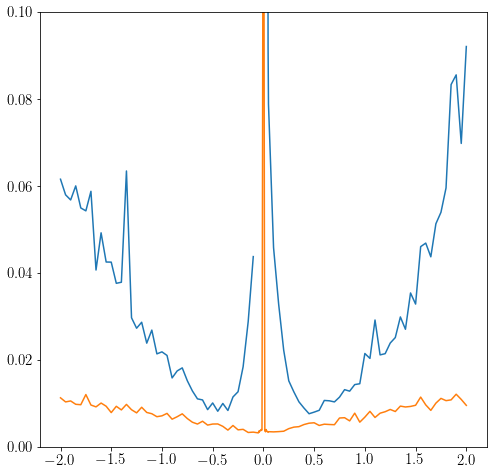

In [80]:
plt.figure(figsize = (8, 8))
plt.plot(rs, lin_avgs)
plt.plot(rs, exp_avgs)
plt.ylim(0, 0.1)

In [73]:
num = 0          # bkgd: normal(-0.1, 1)     sgnl: normal(0.1, 1)
reps = 20
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

filestr = 'models/univariate/mse_ab_param/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

ps = np.round(np.linspace(-2, 2, 101), 2)

In [74]:
m, s

(array(-7.24196412e-06), array(1.00515983))

-2.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.01339450792242244

-1.96
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.014335753198088542

-1.92
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.01454152729364736

-1.88
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.013986625669342131

-1.84
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.014453410104936473

-1.8
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.013337654973746421

-1.76
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.013287520129963353

-1.72
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.014592780560481588

-1.68
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.012196309640802304

-1.64
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.012635470555453204

-1.6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.012698677279309473

-1.56
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0.011415616685608608

-1.52
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:169: RuntimeWarning: divide by zero encountered in true_divide
  return np.squeeze( (f / (1. - f))**(p - 1))
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:169: RuntimeWarning: divide by zero encountered in power
  return np.squeeze( (f / (1. - f))**(p - 1))


inf

0.08
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.12
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.16
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.24
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.28
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.32
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.36
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.44
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.48
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.52
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.56
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.64
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.68
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
inf

0.72
0 1 2 3 4 5 6 7 8

No handles with labels found to put in legend.


0.006346352379969838



Text(0.5, 0, '$p$')

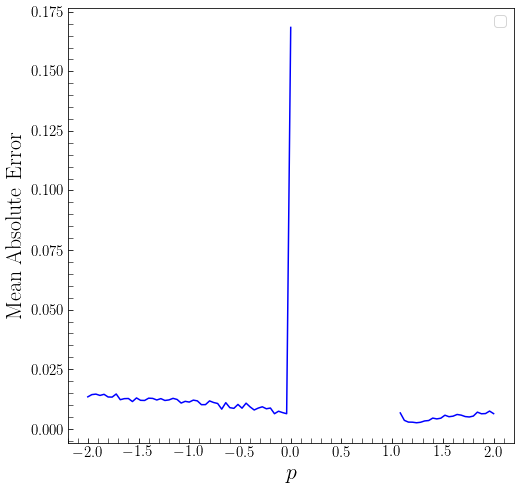

In [75]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p)
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
        print(i, end = ' ')
    print()
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]
    print(avgs[-1])
    print()

avgs = np.array(avgs)

np.save(filestr + 'norm_0.1', avgs)

fig, ax = plt.subplots(figsize = (8, 8))

plt.plot(ps, avgs, c = 'blue')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')